# Guided Backpropagation with PyTorch Hooks

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from PIL import Image

import torch
from torchvision import models

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output, process_grads
from utils.datasets import preprocess_imagenet_image

## Load model and sample image

In [2]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

url = "https://upload.wikimedia.org/wikipedia/commons/a/ae/Sushi_japan.png"
save_image(url, "sushi.png")

Figure saved to /Users/conorosullivan/Documents/XAI/gbp_input.pdf


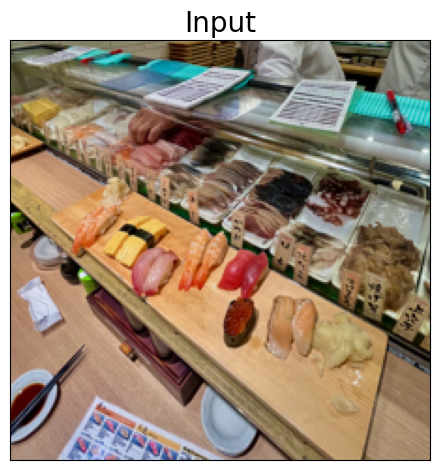

In [3]:
# Load a sample image
img_path = "sushi.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Input")
plt.xticks([])
plt.yticks([])

In [4]:
# Load the pre-trained model (e.g., VGG16)
model = models.vgg16(pretrained=True)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()
model.zero_grad()

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Preprocess the image
original_img_tensor = preprocess_imagenet_image(img_path)
original_img_tensor = original_img_tensor.to(device)

# Clone tensor to avoid in-place operations
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_() # Enable gradient tracking

predictions = model(img_tensor)

# Decode the output
display_imagenet_output(predictions,n=5)

grocery store 0.2256142646074295
tobacco shop 0.21862675249576569
confectionery 0.17332792282104492
bakery 0.10615035146474838
hotdog 0.04379023611545563


tensor(582, device='mps:0')

In [8]:
# Reset gradients
model.zero_grad()

# Select the class with the highest score
target_class = predictions.argmax()

# Compute gradients w.r.t to logit by performing backward pass
predictions[:, target_class].backward()

In [ ]:
# Get the gradients
standard_backprop_grads = img_tensor.grad.detach().cpu().numpy()
print(standard_backprop_grads.shape) # (1, 3, 224, 224)

(1, 3, 224, 224)


Figure saved to /Users/conorosullivan/Documents/XAI/gbp_gradient_sign.pdf


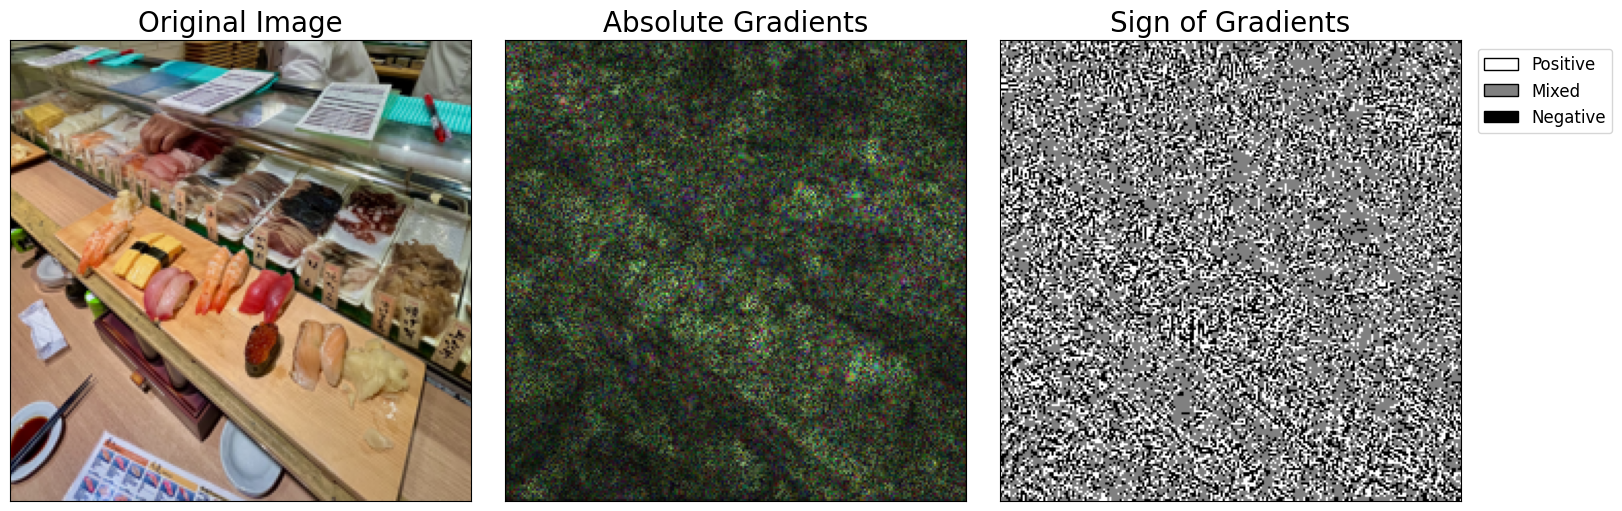

In [ ]:
grads = standard_backprop_grads[0].copy()

abs_grads = process_grads(grads,activation="abs")
raw_grads = process_grads(grads, normalize= False,skew= False)
grad_sign = np.sign(raw_grads)
grad_sign = np.clip(grad_sign, 0, 1)
grad_sign = np.mean(grad_sign, axis=-1)
grad_sign[(grad_sign > 0.) & (grad_sign < 1.)] = 0.5  # replace mixed signs with 0.5


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
ax[0].imshow(np.array(img))
ax[0].set_title("Original Image", fontsize=16)

# Display the gradients
ax[1].imshow(abs_grads)
ax[1].set_title("Absolute Gradients", fontsize=16)

# Display the sign of the gradients
ax[2].imshow(grad_sign,vmax=1, vmin=0, cmap='gray')
ax[2].set_title("Sign of Gradients", fontsize=16)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

legend_elements = [
    mpatches.Patch(facecolor='white',edgecolor='black', label='Positive'),
    mpatches.Patch(facecolor='gray',edgecolor='black', label='Mixed'),
    mpatches.Patch(facecolor='black',edgecolor='black', label='Negative'),
]
fig.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.09, 0.85), fontsize=12)

Figure saved to /Users/conorosullivan/Documents/XAI/gbp_variants_standard_backprop.pdf


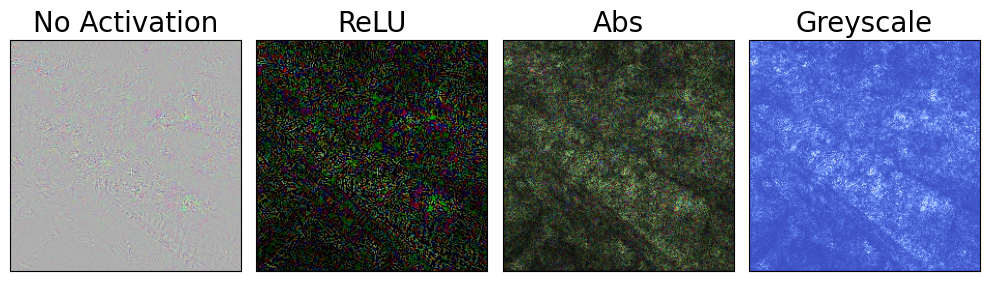

In [ ]:
standard_grads = standard_backprop_grads[0]

# Process the gradients
no_activation_grads = process_grads(standard_grads,activation=None)
relu_grads = process_grads(standard_grads,activation="relu")
abs_grads = process_grads(standard_grads,activation="abs")
grey_grads = process_grads(standard_grads,activation="abs",greyscale=True,skew=False)

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

# Display as an image
ax[0].imshow(no_activation_grads)
ax[0].title.set_text("No Activation")


ax[1].imshow(relu_grads)
ax[1].title.set_text("ReLU")

ax[2].imshow(abs_grads)
ax[2].title.set_text("Abs")

ax[3].imshow(grey_grads, cmap="coolwarm")
ax[3].title.set_text("Greyscale")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

## Hooks for Guided-Backprop

In [ ]:
# Replace all in-place ReLU activations with out-of-place ones
def replace_relu(model):

    for name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU):
            setattr(model, name, torch.nn.ReLU(inplace=False))
            print(f"Replacing ReLU activation in layer: {name}")
        else:
            replace_relu(child)  # Recursively apply to submodules

# Apply the modification to the VGG16 model
replace_relu(model)

Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 3
Replacing ReLU activation in layer: 6
Replacing ReLU activation in layer: 8
Replacing ReLU activation in layer: 11
Replacing ReLU activation in layer: 13
Replacing ReLU activation in layer: 15
Replacing ReLU activation in layer: 18
Replacing ReLU activation in layer: 20
Replacing ReLU activation in layer: 22
Replacing ReLU activation in layer: 25
Replacing ReLU activation in layer: 27
Replacing ReLU activation in layer: 29
Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 4


In [ ]:
# Dictionary to store gradients
gradients = {}

def relu_hook(module, grad_in, grad_out, layer_name):
    """
    Guided Backpropagation Hook: Allows only positive gradients to backpropagate.

    Parameters:
        module (nn.Module): The module where the hook is applied.
        grad_in (tuple of Tensors): Gradients w.r.t. the input of the module.
        grad_out (tuple of Tensors): Gradients w.r.t. the output of the module.
        layer_name (str): Name of the module.
    """

    modified_grad = []  # Create a list to store modified gradients

    for g in grad_in:
        if g is not None:
            modified_grad.append(torch.clamp(g, min=0.0))  # Keep only positive gradients
        else:
            modified_grad.append(None)  # Preserve any None values in grad_in

    # Save gradients
    gradients[layer_name] = modified_grad[0].detach().cpu().numpy().squeeze()

    return tuple(modified_grad)

In [ ]:
# Register the hook for all layers
for name, layer in model.named_modules():

    # Update the hook for ReLU layers
    if isinstance(layer, torch.nn.ReLU):
        layer.register_backward_hook(lambda m,
                                     gi,
                                     go,
                                     n=name:
                                     relu_hook(m, gi, go, n))
        print(f"Relu hook registered for {name}")

Relu hook registered for features.1
Relu hook registered for features.3
Relu hook registered for features.6
Relu hook registered for features.8
Relu hook registered for features.11
Relu hook registered for features.13
Relu hook registered for features.15
Relu hook registered for features.18
Relu hook registered for features.20
Relu hook registered for features.22
Relu hook registered for features.25
Relu hook registered for features.27
Relu hook registered for features.29
Relu hook registered for classifier.1
Relu hook registered for classifier.4


## Guided-backprop for target logit

In [ ]:
# Reset gradients
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_()
model.zero_grad()

# Get the model's prediction (with gradient calculation)
predictions = model(img_tensor)

# Select the class with the highest score
target_class = predictions.argmax()

# Compute gradients w.r.t to logit by performing backward pass
predictions[:, target_class].backward()

Figure saved to /Users/conorosullivan/Documents/XAI/gbp_standard_vs_guided_backprop.pdf


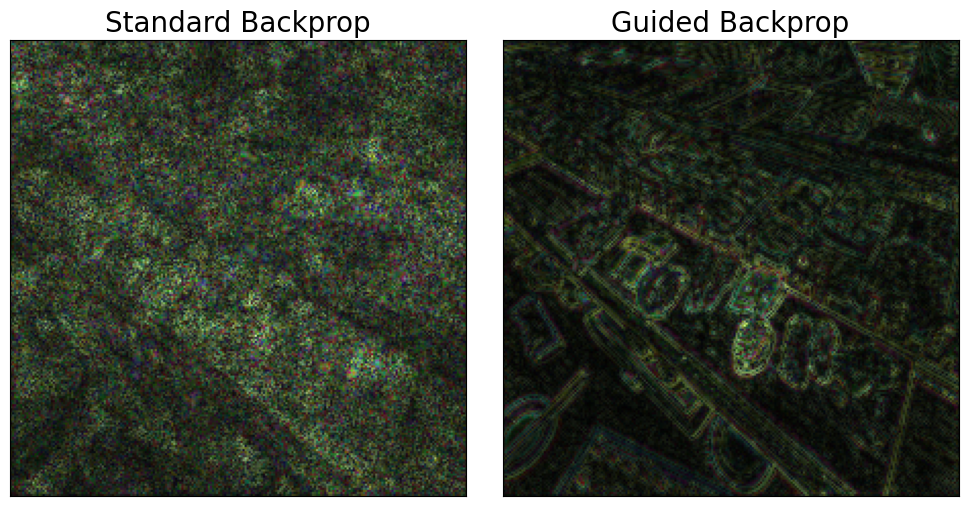

In [ ]:
# Get the image gradients
grads = img_tensor.grad.detach().cpu().numpy().squeeze()

grads = process_grads(grads,activation='abs')

fig,ax = plt.subplots(1,2,figsize=(10,5))

# Display the gradients
ax[0].imshow(abs_grads)
ax[0].title.set_text("Standard Backprop")

ax[1].imshow(grads)
ax[1].title.set_text("Guided Backprop")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

## Guided backprop from intermediate layers

(64, 224, 224)
Figure saved to /Users/conorosullivan/Documents/XAI/gbp_first_layer_feature_map.pdf


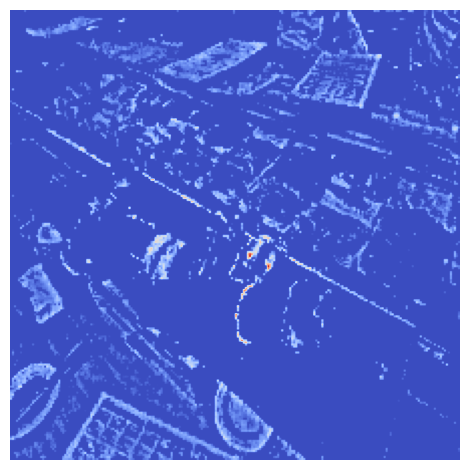

In [ ]:
# Gradients from the first layer
layer = 'features.1'

# Get gradients for all feature map in layer
layer_grads = gradients[layer]
print(layer_grads.shape)

# Select a random feature map
i = np.random.randint(0, layer_grads.shape[0])
feature_map_grads = layer_grads[i]

# Processing the gradients
feature_map_grads = process_grads(feature_map_grads)

# Display the gradients
plt.imshow(feature_map_grads, cmap="coolwarm")
plt.axis("off")

features.1: (64, 224, 224)
features.6: (128, 112, 112)
features.13: (256, 56, 56)
features.22: (512, 28, 28)
Figure saved to /Users/conorosullivan/Documents/XAI/gbp_multiple_layers.pdf


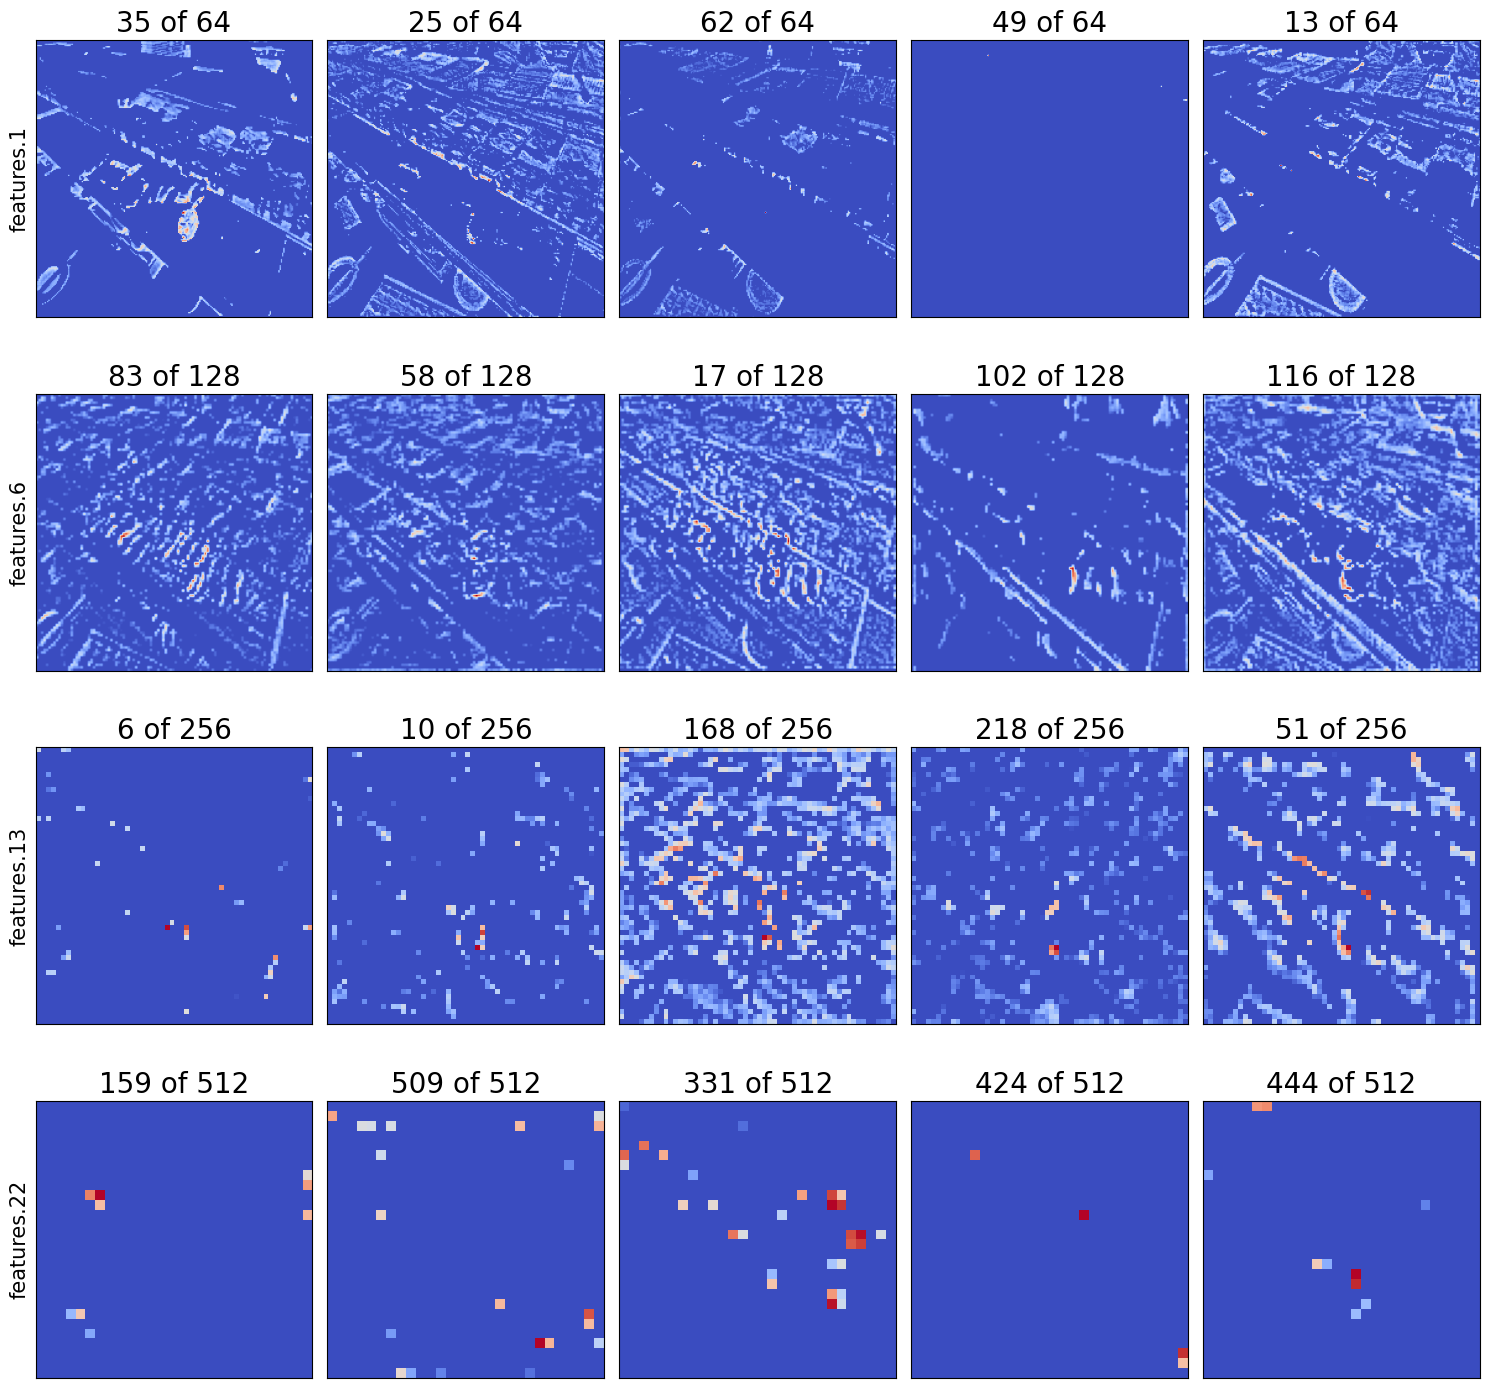

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(15, 15))

for i,layer in enumerate(['features.1','features.6','features.13','features.22']):
    layer_grads = gradients[layer]
    print(f"{layer}: {layer_grads.shape}")

    for j in range(5):
        n_features = layer_grads.shape[0]
        r = np.random.randint(0, n_features)

        feature_map_grads = layer_grads[r]
        feature_map_grads = process_grads(feature_map_grads)

        ax[i, j].imshow(feature_map_grads, cmap="coolwarm")

        ax[i, j].set_title(f"{r} of {n_features}")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

    ax[i, 0].set_ylabel(f"{layer}", fontsize=15)

plt.tight_layout()

## Guided backprop from activations

In [ ]:
# Dictionary to store activations
activations = {}

def act_hook_fn(module, input, output, layer_name):
    """
    Hook function to store activations of a layer.

    Parameters:
        module (nn.Module): The module where the hook is applied.
        input (tuple of Tensors): Incoming data to the layer.
        output (Tensor): Outgoing data from the layer.
        layer_name (str): The name of the layer.
    """
    # Store the activations as tensors
    activations[layer_name] = output.clone()
    print(f"Activation stored for {layer_name}")


# Register hooks on all convolutional layers
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(lambda m, i, o, n=name: act_hook_fn(m, i, o, n))
        print(f"Forward hook registered for {name}")

Forward hook registered for features.0
Forward hook registered for features.2
Forward hook registered for features.5
Forward hook registered for features.7
Forward hook registered for features.10
Forward hook registered for features.12
Forward hook registered for features.14
Forward hook registered for features.17
Forward hook registered for features.19
Forward hook registered for features.21
Forward hook registered for features.24
Forward hook registered for features.26
Forward hook registered for features.28


In [ ]:
# Reset gradients
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_()
model.zero_grad()

# Perform a forward pass
predictions = model(img_tensor)

# Get the activations of the conv layers
layer_act = activations['features.21'][0]
print(layer_act.shape) # (512, 28, 28)

Activation stored for features.0
Activation stored for features.2
Activation stored for features.5
Activation stored for features.7
Activation stored for features.10
Activation stored for features.12
Activation stored for features.14
Activation stored for features.17
Activation stored for features.19
Activation stored for features.21
Activation stored for features.24
Activation stored for features.26
Activation stored for features.28
torch.Size([512, 28, 28])


Figure saved to /Users/conorosullivan/Documents/XAI/gbp_activations_conv_layer.pdf


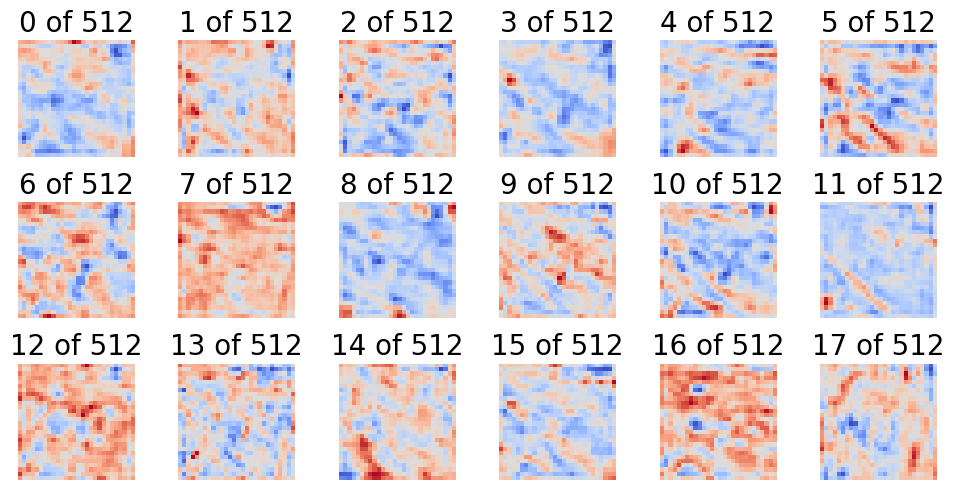

In [ ]:
# Plot the activations
fig, ax = plt.subplots(3, 6, figsize=(10, 5))

for i, act in enumerate(layer_act[0:18]):

    act_copy = act.clone().detach().cpu().numpy()
    act_copy = process_grads(act_copy,skew= False)

    ax[i // 6, i % 6].imshow(act_copy, cmap="coolwarm")
    ax[i // 6, i % 6].set_title(f"{i} of {layer_act.shape[0]}")
    ax[i // 6, i % 6].axis("off")

plt.tight_layout()

In [ ]:
# Compute gradients w.r.t element of the activation map
layer_act[0][14,14].backward()

Figure saved to /Users/conorosullivan/Documents/XAI/gbp_input_gradients.pdf


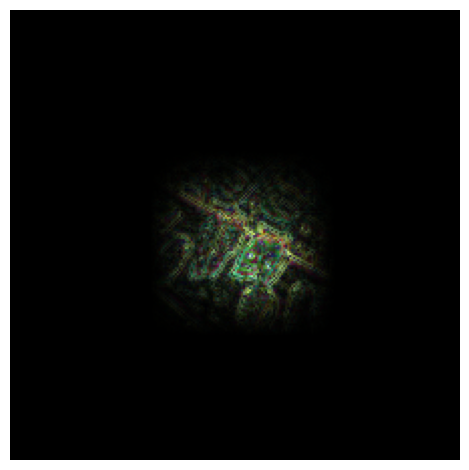

In [ ]:
# Get the gradients of input image
grads = img_tensor.grad.detach().cpu().numpy().squeeze()

grads = process_grads(grads, activation="abs")

plt.imshow(grads)
plt.axis("off")

Activation stored for features.0
Activation stored for features.2
Activation stored for features.5
Activation stored for features.7
Activation stored for features.10
Activation stored for features.12
Activation stored for features.14
Activation stored for features.17
Activation stored for features.19
Activation stored for features.21
Activation stored for features.24
Activation stored for features.26
Activation stored for features.28
Activation stored for features.0
Activation stored for features.2
Activation stored for features.5
Activation stored for features.7
Activation stored for features.10
Activation stored for features.12
Activation stored for features.14
Activation stored for features.17
Activation stored for features.19
Activation stored for features.21
Activation stored for features.24
Activation stored for features.26
Activation stored for features.28
Activation stored for features.0
Activation stored for features.2
Activation stored for features.5
Activation stored for fea

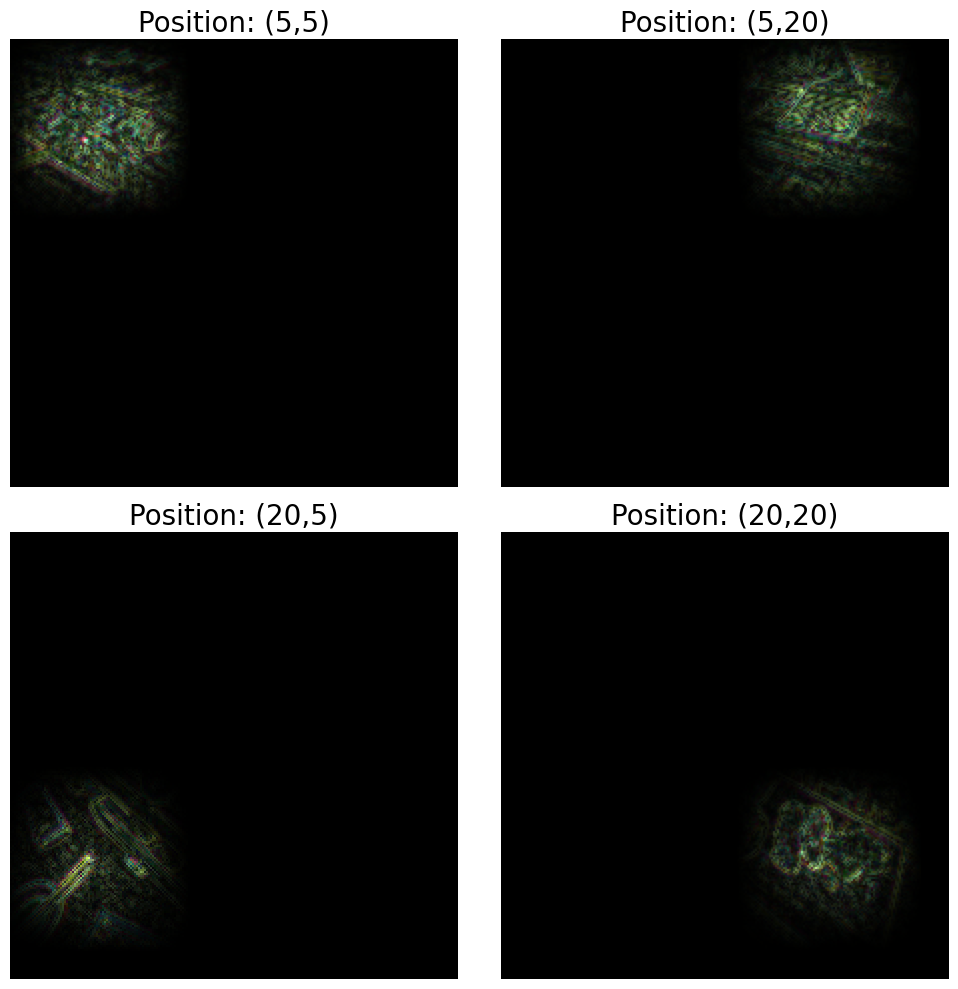

In [ ]:
positions = [(5,5),(5,20),(20,5),(20,20)]

fig,ax = plt.subplots(2,2,figsize=(10,10))

for i, (x,y) in enumerate(positions):

    img_tensor = original_img_tensor.clone()
    img_tensor.requires_grad_()
    model.zero_grad() # Reset gradients

    predictions = model(img_tensor)

    # Get the activations of the conv layers
    layer_act = activations['features.21'][0]
    layer_act[0][x,y].backward()

    grads = img_tensor.grad.cpu().numpy().squeeze()
    grads = process_grads(grads,activation="abs")

    ax[i // 2, i % 2].imshow(grads)
    ax[i // 2, i % 2].set_title(f"Position: ({x},{y})")
    ax[i // 2, i % 2].axis("off")